# IMPORTANTE: Augmentation con noise in range

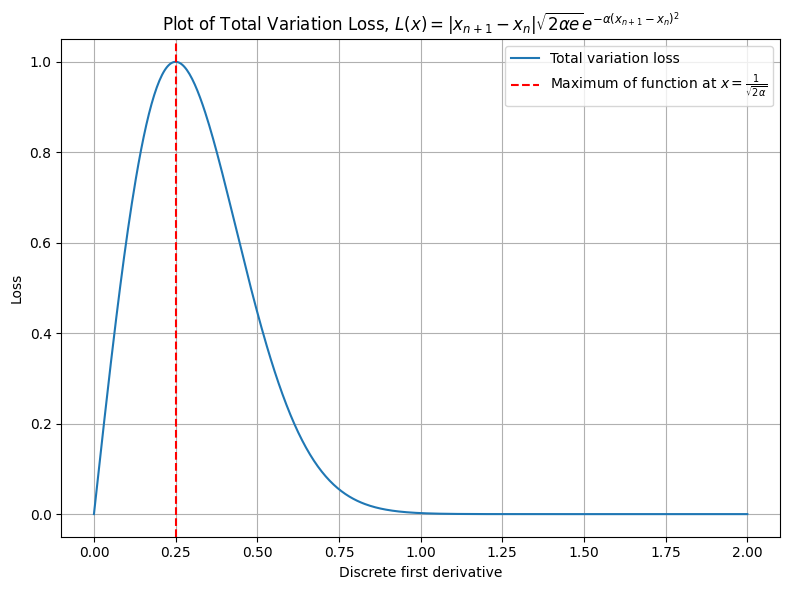

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the equation parameters and timepoints
def total_variation_loss(a, x):
    return np.sqrt(2 * np.e * a) * x * np.exp(-a * x**2)

a = 8  # Example scalar value for 'a'
x = np.linspace(0, 2, 500)  # Define timepoints

# Calculate the function values
y = total_variation_loss(a, x)

# Calculate the position of the maximum
x_max = 1 / np.sqrt(2 * a)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Total variation loss')

# Add vertical line at x_max
plt.axvline(x=x_max, color='red', linestyle='--', label=r'Maximum of function at $x=\frac{1}{\sqrt{2\alpha}}$')

# Add labels and legend
plt.xlabel('Discrete first derivative')
plt.ylabel('Loss')
plt.title(r'Plot of Total Variation Loss, $L(x) = |x_{n+1}-x_n| \sqrt{2\alpha e}e^{-\alpha (x_{n+1}-x_n)^2}$')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

def augment_data(X_train, Y_train, shift_range=(-20, +20), amplitude_range=(0.5, 2), noise_std=(0.05,0.1), stretch_ratio=0.6,plot_times=False):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train Tensors for the BOLD signal and predicted signals (Y).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    num_samples = X_train.shape[0]
    if plot_times:
        x,y = X_train[0,:],Y_train[0,:]
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.title("Original signal")

        plt.legend()
        plt.show()

    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)
        if plot_times:

            x,y = shifted_X,shifted_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')            
            plt.title("Signal after shift")

            plt.legend()
            plt.show()
        

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor
        if plot_times:

            x,y = scaled_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.title("Signal after scaling")
            plt.legend()
            plt.show()
                
        # 4. Add Gaussian noise
        noise_level=np.random.uniform(noise_std[0], noise_std[1])
        noise_std_value = noise_level*torch.max(scaled_Y).item()
        noise_X = torch.normal(mean=0, std=noise_std_value, size=scaled_X.shape, device=scaled_X.device)
        noisy_X = scaled_X + noise_X
        if plot_times:

            x,y = noisy_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.title(f"Signal with added noise, noise added: {20*np.log10((noise_level**2/torch.mean(scaled_X**2).item())):.4f}, noise lev{noise_level:.4f}")

            plt.legend()
            plt.show()
            plot_times-=1
        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    
    return augmented_X_tensor, augmented_Y_tensor


### Loss


In [ ]:
def gaussian_tv_penalty(predictions, alpha=8):
    # max is at 1/sqrt(2*alpha), needs to be searched for max gain
    # diffs is a first derivative approx
    diffs = predictions[:,1:,:] - predictions[:,:-1,:]
    # exponential weights to punish small variations
    weights = np.sqrt(2*alpha*np.e)*torch.exp(-alpha * diffs**2)
    return torch.mean(torch.abs(diffs) * weights) # normalized to have max value of 1 and min of zero, 

def anti_constant_penalty(predictions):
    # Encourages non-constant solutions by penalizing non unitary variances - input and target data needs to be normalized
    varmean= torch.mean(torch.var(predictions,dim=1)) 
    return torch.pow(varmean-1,2)
def combined_penalty(predictions, alpha=8, lambda_tv=1, lambda_const=1):
    tv_loss = gaussian_tv_penalty(predictions, alpha)
    const_loss = anti_constant_penalty(predictions)
    return (lambda_tv * tv_loss + lambda_const * const_loss)/(lambda_tv+lambda_const)


# For training plug and play -- maybe?
def blocky_loss_criterion(predictions, ground_truth, data_fidelity_criterion=nn.L1Loss(), smoothness_criterion=combined_penalty, lambda_val=2.6):
    return data_fidelity(predictions,ground_truth) + lambda_val * smoothness_criterion(predictions)

# for training as used until now
def blocky_loss(data_loss, smoothness_loss, lambda_val=2.6):
    return data_loss + lambda_val * smoothness_loss


## To extract varoius losses
l'idea è tipo fare results come dizionario, e poi fare un metadizionario dove ti salvi anche il modello che hai usato

In [ ]:
test_dataset = TensorDataset(X_test_def, Y_test_def)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
lambda_val=2.6 ### Pretuned hyperparameter - do not touch
model.eval()

results = {
    "MSE": {},
    "MAE": {},
    "Concatenated": {},
    "Smoothness loss": {},
    "model": {}
}

# Not concatenated
dup = False
MAE_list = []
MSE_list = []
smoothness_loss_list = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        if dup:
            batch_x = torch.cat([batch_x, batch_x], dim=1)
            batch_y = torch.cat([batch_y, batch_y], dim=1)
        predictions = model(batch_x)
        MAE = nn.L1Loss()(predictions, batch_y)
        MSE = nn.MSELoss()(predictions, batch_y)
        smoothness_loss = lambda_val * combined_penalty(predictions)
        MAE_list.append(MAE.item())
        MSE_list.append(MSE.item())
        smoothness_loss_list.append(smoothness_loss.item())

avg_test_MAE = np.mean(MAE_list)
std_test_MAE = np.std(MAE_list)
avg_test_MSE = np.mean(MSE_list)
std_test_MSE = np.std(MSE_list)
avg_smoothness_loss = np.mean(smoothness_loss_list)
std_smoothness_loss = np.std(smoothness_loss_list)

results["MAE"]["Not concatenated"] = {"avg": avg_test_MAE, "std": std_test_MAE}
results["MSE"]["Not concatenated"] = {"avg": avg_test_MSE, "std": std_test_MSE}
results["Smoothness loss"]["Not concatenated"] = {"avg": avg_smoothness_loss, "std": std_smoothness_loss}
results["Concatenated"]["Not concatenated"] = False

print(f"Not concatenated - Average test MAE: {avg_test_MAE:.4f}, STD: {std_test_MAE:.4f}")
print(f"Not concatenated - Average test MSE: {avg_test_MSE:.4f}, STD: {std_test_MSE:.4f}")
print(f"Not concatenated - Average smoothness loss: {avg_smoothness_loss:.4f}, STD: {std_smoothness_loss:.4f}")

# Concatenated
dup = True
MAE_list = []
MSE_list = []
smoothness_loss_list = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        if dup:
            batch_x = torch.cat([batch_x, batch_x], dim=1)
            batch_y = torch.cat([batch_y, batch_y], dim=1)
        predictions = model(batch_x)
        MAE = nn.L1Loss()(predictions, batch_y)
        MSE = nn.MSELoss()(predictions, batch_y)
        smoothness_loss = lambda_val * combined_penalty(predictions)
        MAE_list.append(MAE.item())
        MSE_list.append(MSE.item())
        smoothness_loss_list.append(smoothness_loss.item())

avg_test_MAE = np.mean(MAE_list)
std_test_MAE = np.std(MAE_list)
avg_test_MSE = np.mean(MSE_list)
std_test_MSE = np.std(MSE_list)
avg_smoothness_loss = np.mean(smoothness_loss_list)
std_smoothness_loss = np.std(smoothness_loss_list)

results["MAE"]["Concatenated"] = {"avg": avg_test_MAE, "std": std_test_MAE}
results["MSE"]["Concatenated"] = {"avg": avg_test_MSE, "std": std_test_MSE}
results["Smoothness loss"]["Concatenated"] = {"avg": avg_smoothness_loss, "std": std_smoothness_loss}
results["Concatenated"]["Concatenated"] = True

print(f"Concatenated - Average test MAE: {avg_test_MAE:.4f}, STD: {std_test_MAE:.4f}")
print(f"Concatenated - Average test MSE: {avg_test_MSE:.4f}, STD: {std_test_MSE:.4f}")
print(f"Concatenated - Average smoothness loss: {avg_smoothness_loss:.4f}, STD: {std_smoothness_loss:.4f}")


### Poi da fare su nuovi task, su nuovi task non serve concatenare ma teniamo MSE,MAE e smoothness

# Modelli

In [ ]:
RNNCNNDeconvolutionRNN(input_dim, hidden_dim, kernel_size)
RNNCNNDeconvolutionRNNbi(input_dim, hidden_dim, kernel_size) # solo se hai voglia, probabilmente va meglio ma non so
# dimitri forse non so se si lascia convincere di vederlo anche storto l'input
LSTM1l(input_size, hidden_size, output_size=1)
LSTM3l(input_size, hidden_size, output_size=1)
LSTMConv(input_size, hidden_size, output_size=1)
ConvLSTM(input_size, hidden_size, output_size=1)
LSTM_attention(input_size, hidden_size, output_size=1)
biLSTM(input_size, hidden_size, output_size=1)
PureConv(input_dim, hidden_dim, kernel_size)

In [ ]:
import torch
import torch.nn as nn

class OutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=3) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class KernelRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
        self.fc = nn.Linear(hidden_dim, kernel_size)  # Output kernel weights

    def forward(self, y):
        # y: [batch_size, time_steps, input_dim]
        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
        
        # Select the last time step's output
        last_output = rnn_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Generate a single kernel for the entire batch
        kernel = self.fc(last_output)  # Shape: [batch_size, kernel_size]
        return kernel  # Shape: [batch_size, kernel_size]
# [batch_size, time_steps, kernel_size]

class DeconvolutionCNN(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNN, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        
        # Move time dimension to the end of the channel dimension
        # y: [batch_size, 1, time_steps]
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)  # kernel: [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Apply padding to the entire batch at once
        # F.pad can handle batching: input [batch_size, C, L] -> output [batch_size, C, L + padding]
        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect') 
        # padded_y: [batch_size, 1, time_steps + total_padding]

        # Reshape input for grouped convolution:
        # We want each batch sample to be treated as a separate group.
        # Convert [batch_size, 1, length] to [1, batch_size, length]
        padded_y = padded_y.permute(1, 0, 2)  # Now: [1, batch_size, length]

        # Perform grouped convolution
        # groups = batch_size, in_channels = batch_size, out_channels = batch_size
        # kernel: [batch_size, 1, kernel_size]
        # input: [1, batch_size, length]
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))

        # x_hat: [1, batch_size, time_steps]
        # Permute back: [batch_size, 1, time_steps]
        x_hat = x_hat.permute(1, 0, 2)

        # Finally, permute to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)

        return x_hat
    
# Combined RNN-CNN Model
class RNNCNNDeconvolutionRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolutionRNN, self).__init__()
        self.kernel_rnn = KernelRNN(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNN(kernel_size)
        self.output_rnn = OutputRNN(input_dim,hidden_dim,output_dim)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        x_out = self.output_rnn(x_hat)
        return x_out  # Shape: [batch_size, timepoints, 1]

In [ ]:
import torch
import torch.nn as nn

class OutputRNNbi(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(OutputRNNbi, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=3,bidirectional=True) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size*2, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class KernelRNNbi(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(KernelRNNbi, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2,bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, kernel_size)  # Output kernel weights

    def forward(self, y):
        # y: [batch_size, time_steps, input_dim]
        rnn_out, _ = self.rnn(y)  # RNN output: [batch_size, time_steps, hidden_dim]
        
        # Select the last time step's output
        last_output = rnn_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Generate a single kernel for the entire batch
        kernel = self.fc(last_output)  # Shape: [batch_size, kernel_size]
        return kernel  # Shape: [batch_size, kernel_size]
# [batch_size, time_steps, kernel_size]

class DeconvolutionCNNbi(nn.Module):
    def __init__(self, kernel_size):
        super(DeconvolutionCNNbi, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, y, kernel):
        # y: [batch_size, time_steps, 1]
        # kernel: [batch_size, kernel_size]
        
        # Move time dimension to the end of the channel dimension
        # y: [batch_size, 1, time_steps]
        y = y.permute(0, 2, 1)
        kernel = kernel.unsqueeze(1)  # kernel: [batch_size, 1, kernel_size]

        # Calculate padding
        total_padding = self.kernel_size - 1
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Apply padding to the entire batch at once
        # F.pad can handle batching: input [batch_size, C, L] -> output [batch_size, C, L + padding]
        padded_y = F.pad(y, (left_padding, right_padding), mode='reflect') 
        # padded_y: [batch_size, 1, time_steps + total_padding]

        # Reshape input for grouped convolution:
        # We want each batch sample to be treated as a separate group.
        # Convert [batch_size, 1, length] to [1, batch_size, length]
        padded_y = padded_y.permute(1, 0, 2)  # Now: [1, batch_size, length]

        # Perform grouped convolution
        # groups = batch_size, in_channels = batch_size, out_channels = batch_size
        # kernel: [batch_size, 1, kernel_size]
        # input: [1, batch_size, length]
        x_hat = F.conv1d(padded_y, kernel, groups=kernel.size(0))

        # x_hat: [1, batch_size, time_steps]
        # Permute back: [batch_size, 1, time_steps]
        x_hat = x_hat.permute(1, 0, 2)

        # Finally, permute to [batch_size, time_steps, 1]
        x_hat = x_hat.permute(0, 2, 1)

        return x_hat
    
# Combined RNN-CNN Model
class RNNCNNDeconvolutionRNNbi(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,output_dim=1):
        super(RNNCNNDeconvolutionRNNbi, self).__init__()
        self.kernel_rnn = KernelRNNbi(input_dim, hidden_dim, kernel_size)
        self.deconv_cnn = DeconvolutionCNNbi(kernel_size)
        self.output_rnn = OutputRNNbi(input_dim,hidden_dim,output_dim)
    def forward(self, y):
        kernel = self.kernel_rnn(y)  # Predict kernel with RNN
        x_hat = self.deconv_cnn(y, kernel)  # Deconvolve signal
        x_out = self.output_rnn(x_hat)
        return x_out  # Shape: [batch_size, timepoints, 1]

In [ ]:
# ***************************************************
#                         MODELS
# ***************************************************

import torch
import torch.nn as nn


# LSTM CLASSIC

class LSTM3l(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM3l, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=3) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output

class LSTM1l(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM1l, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=1) # Either GRU or LSTM
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output

    def forward(self, x):
        # Pass through RNN
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
        
        # Apply fully connected layer
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
        return output




# CONV + LSTM

class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(ConvLSTM, self).__init__()
         # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        
        # RNN Layer (LSTM or GRU)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=3, dropout=dropout_prob)
       
       # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass through CNN
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Reshape for RNN input
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
        
        # Pass through RNN
        rnn_out, _ = self.rnn(x)
        
        # Pass the RNN output (all time steps) through the FC layer
        output = self.fc(rnn_out)  # (batch_size, seq_len, output_size)
        return output




# LSTM with Attention Mechanism

class LSTM_attention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTM_attention, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        
        # Apply attention mechanism at each time step
        attn_weights = F.softmax(self.attn(lstm_out), dim=2)  # Shape: (batch_size, seq_len, hidden_size)
        weighted_out = attn_weights * lstm_out  # Apply attention: (batch_size, seq_len, hidden_size)
        
        # Pass weighted outputs through fully connected layer
        output = self.fc(weighted_out)  # Shape: (batch_size, seq_len, output_size)
        return output



# Bidirectional LSTM

class biLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(biLSTM, self).__init__()
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3, bidirectional=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, _ = self.bilstm(x)  # lstm_out: (batch_size, seq_len, hidden_size * 2)
        
        # Use the output from the last time step
        output = self.fc(lstm_out)  # Last time step output
        return output





#only conv

#First Layer: Captures low-level features like edges, basic patterns, or simple variations in the data.
#Second Layer: Detects combinations of low-level features to form more abstract patterns or structures.
#Third Layer: Extracts high-level representations, such as complex temporal dependencies or global patterns across the input.


class PureConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, output_dim=1, dropout_prob=0.2):
        super(PureConv, self).__init__()
        
        # Remove padding from the conv layers and do manual padding
        self.conv1 = nn.Conv1d(input_dim, input_dim, kernel_size=kernel_size, padding=0)    
        self.conv2 = nn.Conv1d(input_dim, input_dim, kernel_size=kernel_size, padding=0)      
        self.conv3 = nn.Conv1d(input_dim, input_dim, kernel_size=kernel_size, padding=0)
        self.dropout = nn.Dropout(dropout_prob)

        self.kernel_size = kernel_size
        self.total_padding = self.kernel_size - 1
        self.left_padding = self.total_padding // 2
        self.right_padding = self.total_padding - self.left_padding

    def forward(self, y):
        # [batch_size, time_steps, channels] -> [batch_size, channels, time_steps]
        x = y.permute(0, 2, 1)

        # Convolution 1 with manual padding
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = F.relu(self.conv1(x))

        # Convolution 2 with manual padding
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = F.relu(self.conv2(x))

        # Convolution 3 with manual padding
        x = self.dropout(x)
        x = F.pad(x, (self.left_padding, self.right_padding), mode='reflect')
        x = self.conv3(x)

        # [batch_size, channels, time_steps] -> [batch_size, time_steps, channels]
        x_out = x.permute(0, 2, 1)
        return x_out
